7# Notebook 2: Trying with last periodicity of 1,2,3,7,14,21,28

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


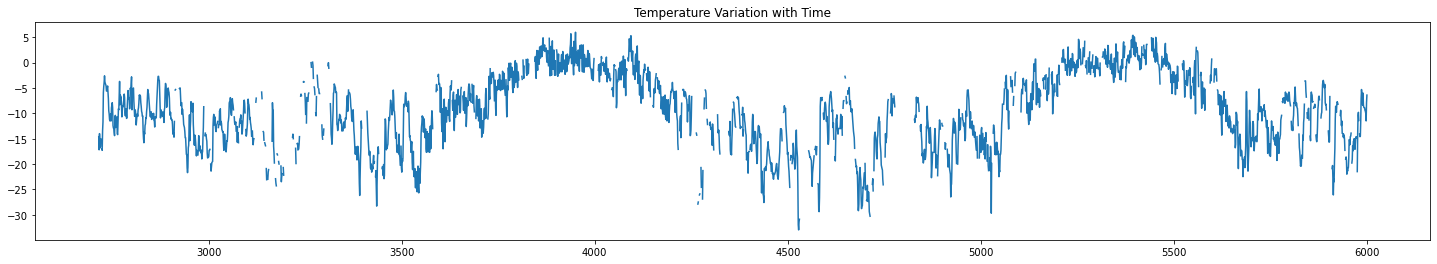

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=[]):
    df = dataframe.copy()
    for lag in prev_n_days:
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=[1,2,3,7,14,21,28])

In [11]:
y

array([-11.5, -11. , -10.1, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[-11.2],
        [-10.1],
        [ -9.5],
        ...,
        [ -2.6],
        [-17. ],
        [-17.2]],

       [[-11.5],
        [-11.2],
        [-10.1],
        ...,
        [ -3.8],
        [-17.3],
        [-14. ]],

       [[-11. ],
        [-11.5],
        [-11.2],
        ...,
        [ -4.1],
        [-13.4],
        [-15.5]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -9.4],
        ...,
        [-11.5],
        [-10.4],
        [-16.1]],

       [[-11.5],
        [-10. ],
        [ -9.6],
        ...,
        [ -7.1],
        [ -9.8],
        [-14.9]],

       [[ -7.9],
        [-11.5],
        [-10. ],
        ...,
        [ -5.3],
        [-11.4],
        [-14.6]]])

In [13]:
y.shape

(1329,)

# Temporal splitting

In [14]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

930 1129


# Standardization

In [15]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [22]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs5',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [24]:
model1 = Sequential()
model1.add(InputLayer((7,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [25]:
cp1 = ModelCheckpoint('model5/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [26]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 106.0904 - root_mean_squared_error: 10.3000

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 23s 461ms/step - loss: 106.0904 - root_mean_squared_error: 10.3000 - val_loss: 23.0757 - val_root_mean_squared_error: 4.8037
Epoch 2/50
29/30 [============================>.] - ETA: 0s - loss: 40.1402 - root_mean_squared_error: 6.3356

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 414ms/step - loss: 40.1129 - root_mean_squared_error: 6.3335 - val_loss: 17.0281 - val_root_mean_squared_error: 4.1265
Epoch 3/50
27/30 [==========================>...] - ETA: 0s - loss: 21.9391 - root_mean_squared_error: 4.6839

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 404ms/step - loss: 21.7183 - root_mean_squared_error: 4.6603 - val_loss: 10.2547 - val_root_mean_squared_error: 3.2023
Epoch 4/50
28/30 [===========================>..] - ETA: 0s - loss: 14.4906 - root_mean_squared_error: 3.8066

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 13s 451ms/step - loss: 14.3591 - root_mean_squared_error: 3.7893 - val_loss: 8.9647 - val_root_mean_squared_error: 2.9941
Epoch 5/50
29/30 [============================>.] - ETA: 0s - loss: 10.5832 - root_mean_squared_error: 3.2532

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 408ms/step - loss: 10.5658 - root_mean_squared_error: 3.2505 - val_loss: 8.5485 - val_root_mean_squared_error: 2.9238
Epoch 6/50
22/30 [=====================>........] - ETA: 0s - loss: 8.2526 - root_mean_squared_error: 2.8727

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 11s 393ms/step - loss: 8.2178 - root_mean_squared_error: 2.8667 - val_loss: 7.4673 - val_root_mean_squared_error: 2.7326
Epoch 7/50
26/30 [=========================>....] - ETA: 0s - loss: 7.1209 - root_mean_squared_error: 2.6685

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 404ms/step - loss: 6.9522 - root_mean_squared_error: 2.6367 - val_loss: 7.2738 - val_root_mean_squared_error: 2.6970
Epoch 8/50
26/30 [=========================>....] - ETA: 0s - loss: 6.2836 - root_mean_squared_error: 2.5067

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 14s 481ms/step - loss: 6.2318 - root_mean_squared_error: 2.4964 - val_loss: 7.2075 - val_root_mean_squared_error: 2.6847
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 6.0395 - root_mean_squared_error: 2.4575 - val_loss: 7.3300 - val_root_mean_squared_error: 2.7074
Epoch 10/50
29/30 [============================>.] - ETA: 0s - loss: 5.5108 - root_mean_squared_error: 2.3475

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 13s 444ms/step - loss: 5.5100 - root_mean_squared_error: 2.3473 - val_loss: 6.5539 - val_root_mean_squared_error: 2.5601
Epoch 11/50
25/30 [========================>.....] - ETA: 0s - loss: 5.4651 - root_mean_squared_error: 2.3377

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 11s 396ms/step - loss: 5.2860 - root_mean_squared_error: 2.2991 - val_loss: 6.2279 - val_root_mean_squared_error: 2.4956
Epoch 12/50
27/30 [==========================>...] - ETA: 0s - loss: 4.9235 - root_mean_squared_error: 2.2189

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 420ms/step - loss: 4.9377 - root_mean_squared_error: 2.2221 - val_loss: 6.1225 - val_root_mean_squared_error: 2.4744
Epoch 13/50
28/30 [===========================>..] - ETA: 0s - loss: 4.8606 - root_mean_squared_error: 2.2047

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 398ms/step - loss: 4.7931 - root_mean_squared_error: 2.1893 - val_loss: 5.9792 - val_root_mean_squared_error: 2.4452
Epoch 14/50
30/30 [==============================] - 0s 9ms/step - loss: 4.6496 - root_mean_squared_error: 2.1563 - val_loss: 6.0957 - val_root_mean_squared_error: 2.4689
Epoch 15/50
26/30 [=========================>....] - ETA: 0s - loss: 4.4597 - root_mean_squared_error: 2.1118

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 11s 393ms/step - loss: 4.5204 - root_mean_squared_error: 2.1261 - val_loss: 5.9177 - val_root_mean_squared_error: 2.4326
Epoch 16/50
30/30 [==============================] - 0s 11ms/step - loss: 4.6715 - root_mean_squared_error: 2.1614 - val_loss: 6.2339 - val_root_mean_squared_error: 2.4968
Epoch 17/50
28/30 [===========================>..] - ETA: 0s - loss: 4.5421 - root_mean_squared_error: 2.1312

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 419ms/step - loss: 4.5540 - root_mean_squared_error: 2.1340 - val_loss: 5.6391 - val_root_mean_squared_error: 2.3747
Epoch 18/50
28/30 [===========================>..] - ETA: 0s - loss: 4.4646 - root_mean_squared_error: 2.1130

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 398ms/step - loss: 4.5111 - root_mean_squared_error: 2.1239 - val_loss: 5.5170 - val_root_mean_squared_error: 2.3488
Epoch 19/50
26/30 [=========================>....] - ETA: 0s - loss: 4.6174 - root_mean_squared_error: 2.1488

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 11s 388ms/step - loss: 4.5544 - root_mean_squared_error: 2.1341 - val_loss: 5.3788 - val_root_mean_squared_error: 2.3192
Epoch 20/50
30/30 [==============================] - 0s 11ms/step - loss: 4.3668 - root_mean_squared_error: 2.0897 - val_loss: 5.7226 - val_root_mean_squared_error: 2.3922
Epoch 21/50
30/30 [==============================] - 0s 11ms/step - loss: 4.2243 - root_mean_squared_error: 2.0553 - val_loss: 5.4565 - val_root_mean_squared_error: 2.3359
Epoch 22/50
29/30 [============================>.] - ETA: 0s - loss: 4.1445 - root_mean_squared_error: 2.0358

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 422ms/step - loss: 4.1384 - root_mean_squared_error: 2.0343 - val_loss: 5.3380 - val_root_mean_squared_error: 2.3104
Epoch 23/50
30/30 [==============================] - 0s 11ms/step - loss: 4.1321 - root_mean_squared_error: 2.0328 - val_loss: 5.7930 - val_root_mean_squared_error: 2.4069
Epoch 24/50
30/30 [==============================] - 0s 10ms/step - loss: 4.3634 - root_mean_squared_error: 2.0889 - val_loss: 5.5405 - val_root_mean_squared_error: 2.3538
Epoch 25/50
30/30 [==============================] - 0s 11ms/step - loss: 4.2398 - root_mean_squared_error: 2.0591 - val_loss: 5.5738 - val_root_mean_squared_error: 2.3609
Epoch 26/50
30/30 [==============================] - 1s 18ms/step - loss: 4.2417 - root_mean_squared_error: 2.0595 - val_loss: 5.5429 - val_root_mean_squared_error: 2.3543
Epoch 27/50
30/30 [==============================] - 0s 10ms/step - loss: 4.0980 - root_mean_squared_error: 2.0244 - val_loss: 5.4695 - val_root_mean_

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 11s 384ms/step - loss: 3.7781 - root_mean_squared_error: 1.9437 - val_loss: 5.3274 - val_root_mean_squared_error: 2.3081
Epoch 35/50
30/30 [==============================] - 0s 10ms/step - loss: 4.3661 - root_mean_squared_error: 2.0895 - val_loss: 5.6269 - val_root_mean_squared_error: 2.3721
Epoch 36/50
30/30 [==============================] - 0s 10ms/step - loss: 4.2237 - root_mean_squared_error: 2.0552 - val_loss: 5.3311 - val_root_mean_squared_error: 2.3089
Epoch 37/50
29/30 [============================>.] - ETA: 0s - loss: 3.8466 - root_mean_squared_error: 1.9613

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 397ms/step - loss: 3.8402 - root_mean_squared_error: 1.9597 - val_loss: 5.1910 - val_root_mean_squared_error: 2.2784
Epoch 38/50
30/30 [==============================] - 0s 11ms/step - loss: 3.7975 - root_mean_squared_error: 1.9487 - val_loss: 5.2587 - val_root_mean_squared_error: 2.2932
Epoch 39/50
30/30 [==============================] - 0s 11ms/step - loss: 3.6151 - root_mean_squared_error: 1.9013 - val_loss: 5.3081 - val_root_mean_squared_error: 2.3039
Epoch 40/50
26/30 [=========================>....] - ETA: 0s - loss: 3.7003 - root_mean_squared_error: 1.9236

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


30/30 [==============================] - 12s 409ms/step - loss: 3.6912 - root_mean_squared_error: 1.9212 - val_loss: 5.0800 - val_root_mean_squared_error: 2.2539
Epoch 41/50
30/30 [==============================] - 0s 10ms/step - loss: 3.7382 - root_mean_squared_error: 1.9334 - val_loss: 5.8978 - val_root_mean_squared_error: 2.4285
Epoch 42/50
30/30 [==============================] - 0s 11ms/step - loss: 3.8822 - root_mean_squared_error: 1.9703 - val_loss: 5.3052 - val_root_mean_squared_error: 2.3033
Epoch 43/50
30/30 [==============================] - 0s 11ms/step - loss: 3.8270 - root_mean_squared_error: 1.9563 - val_loss: 5.2599 - val_root_mean_squared_error: 2.2934
Epoch 44/50
30/30 [==============================] - 0s 16ms/step - loss: 4.1945 - root_mean_squared_error: 2.0480 - val_loss: 5.1135 - val_root_mean_squared_error: 2.2613
Epoch 45/50
30/30 [==============================] - 0s 11ms/step - loss: 3.7657 - root_mean_squared_error: 1.9405 - val_loss: 5.3259 - val_root_mean_

In [27]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [28]:
from tensorflow.keras.models import load_model
model1 = load_model('model5/')

In [29]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

30/30 [==============================] - 0s 3ms/step


In [30]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 4.062961442432885'}>

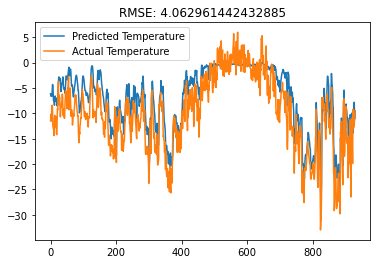

In [31]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.3896895286450435'}>

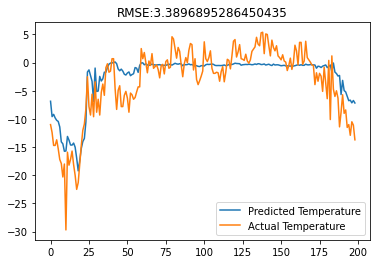

In [32]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:4.172752442358396'}>

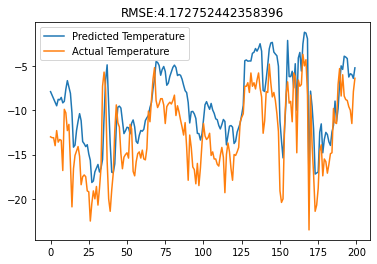

In [33]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [34]:
y.shape

(1329,)